# NLP For Drugs.com Data Set

### Packages Import

In [38]:
### Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.color_palette("Blues", as_cmap=True)

### Standard Packages
import numpy as np
import warnings
import nltk
import re
import pandas as pd
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

### NLTK
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
nltk.download('vader_lexicon')
import contractions

### Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, \
                            accuracy_score, f1_score, recall_score, precision_score

### ImbLearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/albertcc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/albertcc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Bringing in two .tsv files as test and train

In [39]:
# Load in the test and train datasets provided in the data file
data_test = pd.read_csv('data/drugsComTest_raw.tsv', sep='\t')
data_train = pd.read_csv('data/drugsComTrain_raw.tsv', sep='\t')

In [40]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [41]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


### Merge Test and Train dataframes

- The data provided is already split into test and train tsv files. I would like to combine these to not only have more data to work with, but any cleaning could be applied to the merged dataset before splitting into a training and testing set.

In [42]:
merged_df = pd.concat([data_test, data_train], axis=0)

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [44]:
# Drop first column since these appear to be entry numbers
merged_df = merged_df.drop(merged_df.columns[0],axis=1)

In [45]:
# Sanity check that the Unnamed column has been dropped
merged_df.head()

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.""",10.0,"February 28, 2012",22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically.""",8.0,"May 17, 2009",17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused from sugar/carb addiction, which is just as powerful as any drug. I have been taking it for five days, and the good news is, it seems to go to work immediately. I feel hungry before I want food now. I really don&#039;t care to eat; it&#039;s just to fill my stomach. Since I have only been on it a few days, I don&#039;t know if I&#039;ve lost weight (I don&#039;t have a scale), but my clothes do feel a little looser, so maybe a pound or two. I&#039;m hoping that after a few months on this medication, I will develop healthier habits that I can continue without the aid of Contrave.""",9.0,"March 5, 2017",35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend""",9.0,"October 22, 2015",4


- Noticed how 'condition' has some missing values, but other columns are fine

In [46]:
# Drop null values that are in 'condition'

merged_df = merged_df.dropna(subset=['condition'])

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213869 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     213869 non-null  object 
 1   condition    213869 non-null  object 
 2   review       213869 non-null  object 
 3   rating       213869 non-null  float64
 4   date         213869 non-null  object 
 5   usefulCount  213869 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 11.4+ MB


- Reduces the dataset to 213,869 values

In [48]:
merged_df['condition'].value_counts()

Birth Control                                  38436
Depression                                     12164
Pain                                            8245
Anxiety                                         7812
Acne                                            7435
                                               ...  
38</span> users found this comment helpful.        1
Gastric Cance                                      1
Wilson's Disease                                   1
Pruritus of Partial Biliary Obstruction            1
Linear IgA Disease                                 1
Name: condition, Length: 916, dtype: int64

### Looking at unique drugs under 'Birth Control' condition

In [49]:
merged_df['drugName'][merged_df['condition'] =='Birth Control'].nunique()

181

In [50]:
merged_df['drugName'][merged_df['condition'] =='Birth Control'].value_counts()

Etonogestrel                          4394
Ethinyl estradiol / norethindrone     3081
Levonorgestrel                        2884
Nexplanon                             2883
Ethinyl estradiol / levonorgestrel    2107
                                      ... 
Low-Ogestrel-21                          1
Lillow                                   1
Larin Fe 1.5 / 30                        1
Norlyda                                  1
Dasetta 1 / 35                           1
Name: drugName, Length: 181, dtype: int64

In [51]:
# Select the the top 7 birth controls since we want to focus on these
bc_drugs = ['Etonogestrel', 'Ethinyl estradiol / norethindrone', 'Nexplanon', 'Levonorgestrel', 'Ethinyl estradiol / levonorgestrel',
           'Ethinyl estradiol / norgestimate', 'Implanon']

bc_data = merged_df[merged_df['drugName'].isin(bc_drugs)]

In [52]:
bc_data.head()

,drugName,condition,review,rating,date,usefulCount
42,Levonorgestrel,Emergency Contraception,"""I want to share my experience to possibly ease some of the ladies out there.\r\nThe incident occur in Nov 18 (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. This means I was fertile. \r\nwhen we noticed that the condom broke, we immediately bought Plan B One Step and was taken about 45 minutes or an hour later. \r\nThe sooner you take the greater the chances it will work.\r\nSo I waited anxiously, praying I get my period. I felt side effects such as fatigue, bloated, nauseous, cramps, and moody. I was that these might be this pregnancy symptoms. \r\nI waited exactly two weeks and I got my period. I was the happiest person ever. My period was here early by approximately 3-4 days. Good luck.""",10.0,"December 28, 2013",20
50,Etonogestrel,Birth Control,"""I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy.""",3.0,"August 15, 2017",0
53,Etonogestrel,Birth Control,"""So I first got the nexplanon in July of 2014, for the first 5 months I was fine, I didn&#039;t get my period and if I did it was random spotting (very light) but around January I noticed I was very emotional EVERYTHING made me cry. Then my period started coming twice a month with horrific cramps. Or I would spot for 2-3 weeks have a week where I thought It was over and started spotting again. I&#039;ve now had it for 13 months and it does the job because I havent gotten pregnant. But that&#039;s only because I haven&#039;t been able to have sex cause I don&#039;t know when my period is going to come""",5.0,"August 28, 2015",7
70,Ethinyl estradiol / norethindrone,Birth Control,"""I was started on Gildess 1/20 but then was switched to Blisovi as Gildess was recalled. I always had the clearest skin and now that I&#039;ve been taking Blisovi I&#039;ll have random break outs and I&#039;ve gained some weight as well. I do not recommend. I can&#039;t wait to talk to my gynecologist to switch ASAP.""",3.0,"February 7, 2017",4
76,Ethinyl estradiol / levonorgestrel,Birth Control,"""I just started taking this birth control about 12 days ago when I started my period, and I&#039;m still bleeding as if I&#039;m still on my period. The flow is light however the length of my average period is 2 weeks when I wasn&#039;t on birth control. So maybe the medication is altering my system %u2026I do feel nauseous and I crave like crazy. I do feel a little depressed because my period isn&#039;t gone yet but overall it \r\nseems to be a good birth control so far. """,9.0,"July 16, 2011",4


In [53]:
bc_data['drugName'].value_counts()

Levonorgestrel                        4896
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3619
Nexplanon                             2892
Ethinyl estradiol / norgestimate      2682
Ethinyl estradiol / levonorgestrel    2400
Implanon                              1506
Name: drugName, dtype: int64

- Wanted to only include in our dataset the top 7 drugs with condition = birth control, however when we filtered for these drugs we see additional conditions were selected

In [54]:
bc_data['condition'].value_counts()

Birth Control                                 18942
Emergency Contraception                        1651
Abnormal Uterine Bleeding                       812
Acne                                            439
Endometriosis                                   178
Menstrual Disorders                             124
Ovarian Cysts                                   106
Polycystic Ovary Syndrome                        89
Not Listed / Othe                                19
Premenstrual Syndrome                            11
0</span> users found this comment helpful.        8
Postmenopausal Symptoms                           6
2</span> users found this comment helpful.        4
1</span> users found this comment helpful.        2
8</span> users found this comment helpful.        2
Gonadotropin Inhibition                           1
3</span> users found this comment helpful.        1
9</span> users found this comment helpful.        1
4</span> users found this comment helpful.        1
Name: condit

In [55]:
# Let's try to get rid of these conditions that took in the 'Useful' rating as 'condition'
bc_data = bc_data[~bc_data['condition'].str.contains('comment')]

In [56]:
bc_data['condition'].value_counts()

Birth Control                18942
Emergency Contraception       1651
Abnormal Uterine Bleeding      812
Acne                           439
Endometriosis                  178
Menstrual Disorders            124
Ovarian Cysts                  106
Polycystic Ovary Syndrome       89
Not Listed / Othe               19
Premenstrual Syndrome           11
Postmenopausal Symptoms          6
Gonadotropin Inhibition          1
Name: condition, dtype: int64

In [57]:
bc_data['drugName'].value_counts()

Levonorgestrel                        4896
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3619
Nexplanon                             2883
Ethinyl estradiol / norgestimate      2682
Ethinyl estradiol / levonorgestrel    2400
Implanon                              1496
Name: drugName, dtype: int64

In [58]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22378 entries, 42 to 161273
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drugName     22378 non-null  object 
 1   condition    22378 non-null  object 
 2   review       22378 non-null  object 
 3   rating       22378 non-null  float64
 4   date         22378 non-null  object 
 5   usefulCount  22378 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [59]:
# Create new column called 'labels' that will have the target variables
bc_data['sentiment'] = ['Positive' if x > 7.0 else 'Neutral' if 4.0 <= x <= 7.0 else 'Negative' for x in bc_data['rating']]

### Analyze the median rating based on condition

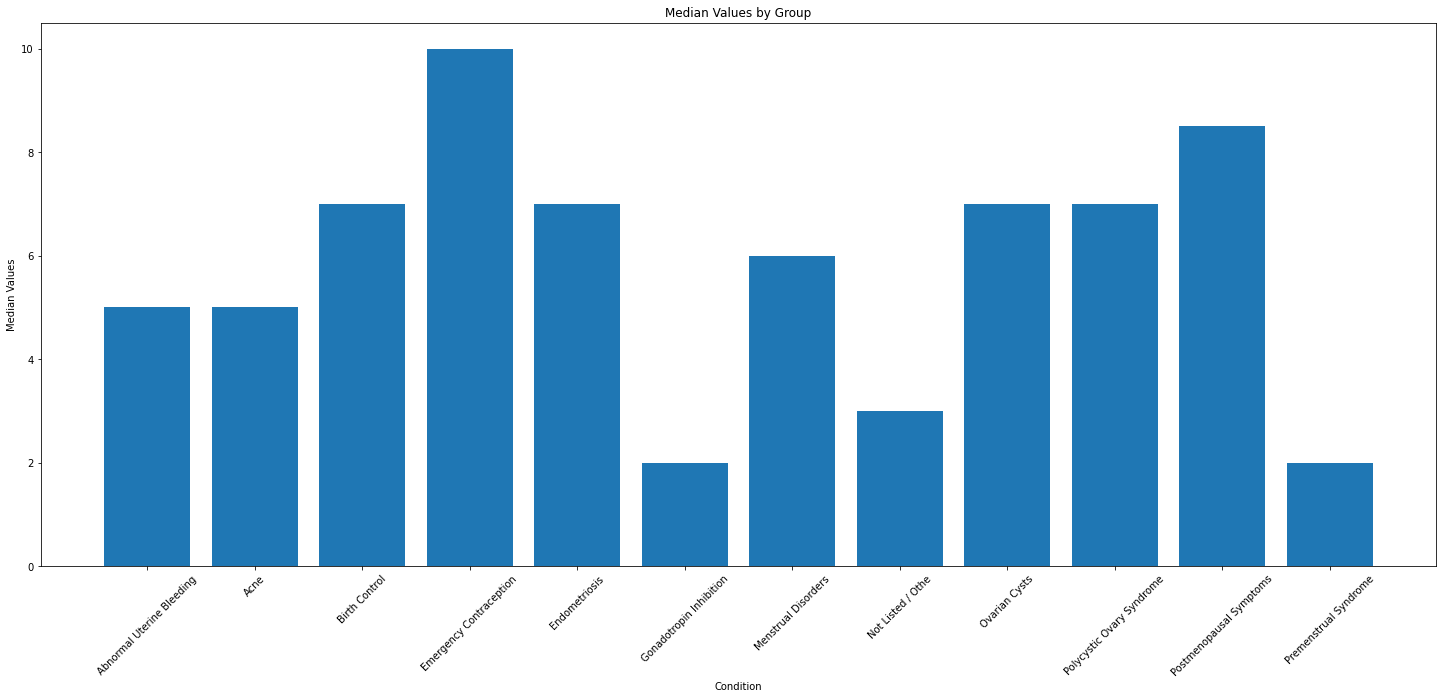

In [60]:
median_values = bc_data.groupby('condition')['rating'].median()

# Create bar chart
fig, ax = plt.subplots(figsize = (25, 10))
ax.bar(median_values.index, median_values.values)
plt.xticks(rotation=45)

# Set axis labels and title
ax.set_xlabel('Condition')
ax.set_ylabel('Median Values')
ax.set_title('Median Values by Group')

# Show plot
plt.show()

In [61]:
bc_data.loc[bc_data['condition'] == 'Emergency Contraception'].rating.value_counts()

10.0    1025
9.0      216
1.0      155
8.0      106
7.0       43
5.0       43
6.0       27
4.0       14
3.0       13
2.0        9
Name: rating, dtype: int64

### Create columns that count emphasis and capital letters in text, as this could express sentiment

In [62]:
### Creating a 'punc_emphasis' column that scores how many exclamation points and question marks are in the text

bc_data['punc_emphasis'] = bc_data['review'].apply(lambda x: sum([1 for char in x if char in ['!', '?']]))

### Creating a 'capt_emphasis' column that scores how many capitalized words are in the text

bc_data['capt_emphasis'] = bc_data['review'].apply(lambda x: sum([1 for word in x.split() if word.isupper()]))

In [63]:
bc_data.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,punc_emphasis,capt_emphasis
42,Levonorgestrel,Emergency Contraception,"""I want to share my experience to possibly ease some of the ladies out there.\r\nThe incident occur in Nov 18 (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. This means I was fertile. \r\nwhen we noticed that the condom broke, we immediately bought Plan B One Step and was taken about 45 minutes or an hour later. \r\nThe sooner you take the greater the chances it will work.\r\nSo I waited anxiously, praying I get my period. I felt side effects such as fatigue, bloated, nauseous, cramps, and moody. I was that these might be this pregnancy symptoms. \r\nI waited exactly two weeks and I got my period. I was the happiest person ever. My period was here early by approximately 3-4 days. Good luck.""",10.0,"December 28, 2013",20,Positive,0,10
50,Etonogestrel,Birth Control,"""I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy.""",3.0,"August 15, 2017",0,Negative,0,8
53,Etonogestrel,Birth Control,"""So I first got the nexplanon in July of 2014, for the first 5 months I was fine, I didn&#039;t get my period and if I did it was random spotting (very light) but around January I noticed I was very emotional EVERYTHING made me cry. Then my period started coming twice a month with horrific cramps. Or I would spot for 2-3 weeks have a week where I thought It was over and started spotting again. I&#039;ve now had it for 13 months and it does the job because I havent gotten pregnant. But that&#039;s only because I haven&#039;t been able to have sex cause I don&#039;t know when my period is going to come""",5.0,"August 28, 2015",7,Neutral,0,12
70,Ethinyl estradiol / norethindrone,Birth Control,"""I was started on Gildess 1/20 but then was switched to Blisovi as Gildess was recalled. I always had the clearest skin and now that I&#039;ve been taking Blisovi I&#039;ll have random break outs and I&#039;ve gained some weight as well. I do not recommend. I can&#039;t wait to talk to my gynecologist to switch ASAP.""",3.0,"February 7, 2017",4,Negative,0,5
76,Ethinyl estradiol / levonorgestrel,Birth Control,"""I just started taking this birth control about 12 days ago when I started my period, and I&#039;m still bleeding as if I&#039;m still on my period. The flow is light however the length of my average period is 2 weeks when I wasn&#039;t on birth control. So maybe the medication is altering my system %u2026I do feel nauseous and I crave like crazy. I do feel a little depressed because my period isn&#039;t gone yet but overall it \r\nseems to be a good birth control so far. """,9.0,"July 16, 2011",4,Positive,0,5


### Sentiment Analysis Against Condition
- Within the conditions we have selected, how do the reviews look pertaining to each condition?

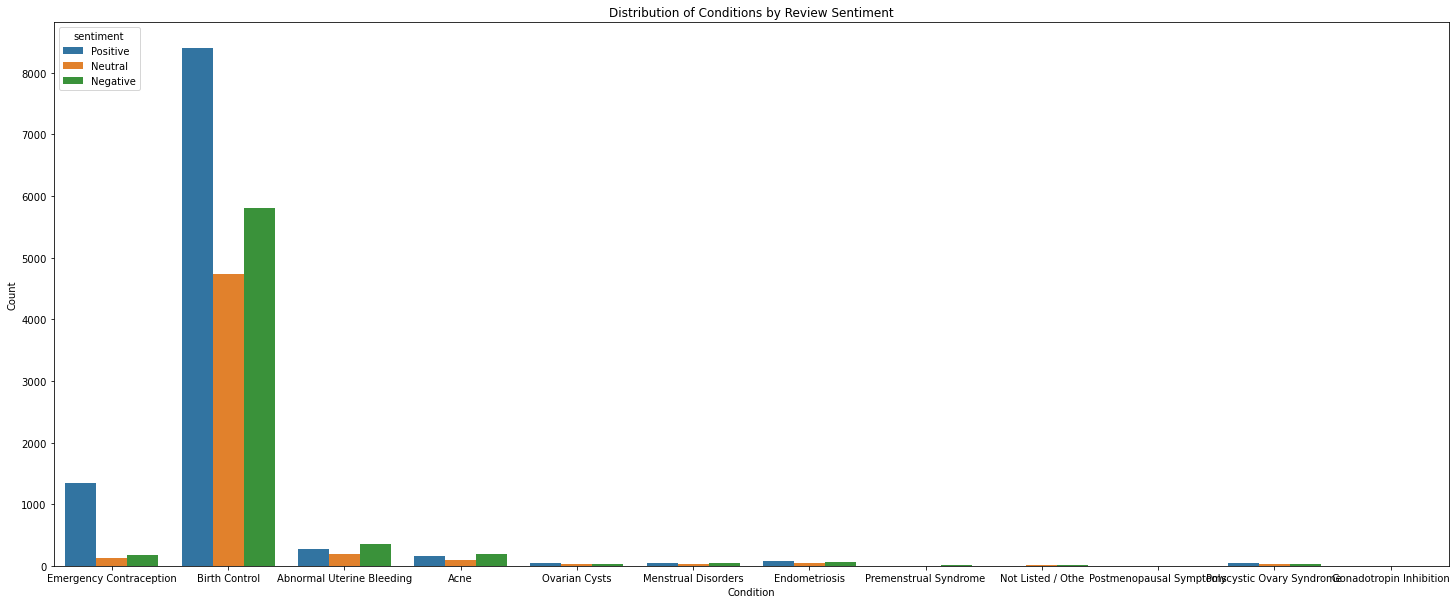

In [64]:
# Let's try plotting sentiment against groups

fig = plt.figure(figsize = (25, 10))

hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(x='condition', hue='sentiment', data=bc_data, hue_order=hue_order, palette='tab10')

# plt.xticks(rotation=45)

plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Distribution of Conditions by Review Sentiment');

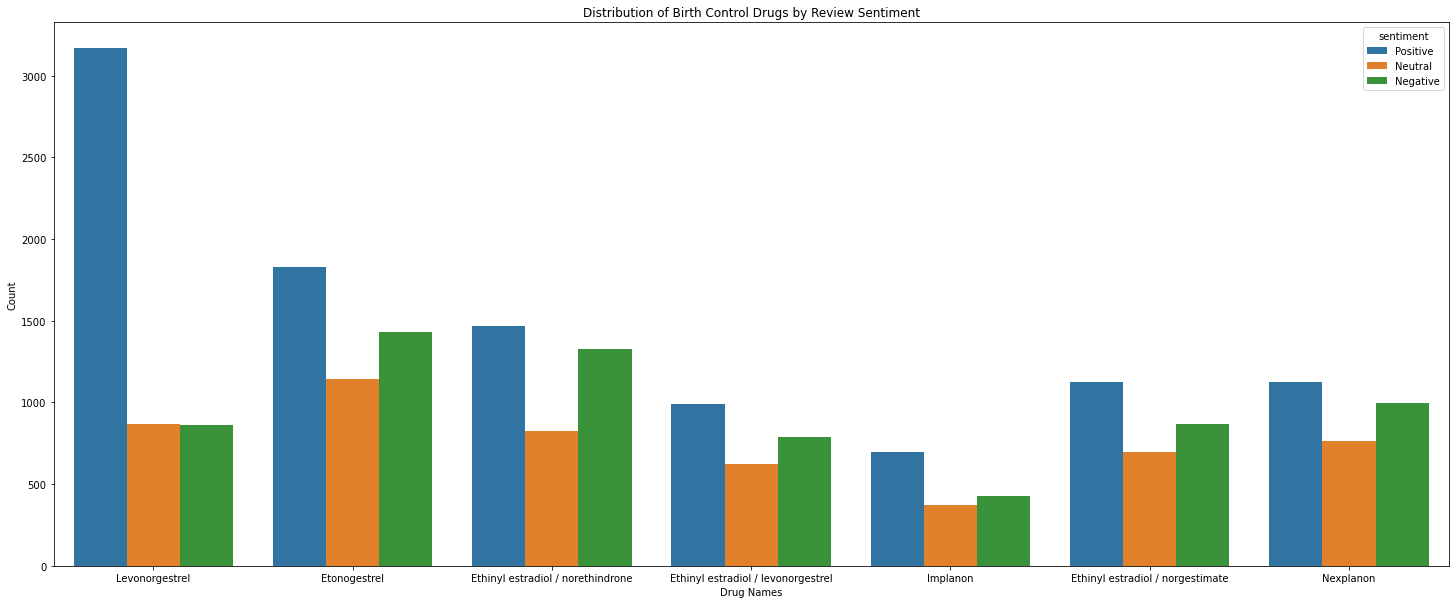

In [65]:
# Let's try plotting sentiment against groups

fig = plt.figure(figsize = (25, 10))


sns.countplot(x='drugName', hue='sentiment', data=bc_data, hue_order=hue_order, palette='tab10')

# plt.xticks(rotation=45)
hue_order = ['Positive', 'Neutral', 'Negative']
plt.xlabel('Drug Names')
plt.ylabel('Count')
plt.title('Distribution of Birth Control Drugs by Review Sentiment');

### Can we do anything with 'UsefulCount'?

In [66]:
bc_data['usefulCount'].value_counts(bins=3)

(-1.248, 415.667]     22371
(415.667, 831.333]        6
(831.333, 1247.0]         1
Name: usefulCount, dtype: int64

In [67]:
bc_data['usefulCount'].min()

0

In [68]:
bc_data['usefulCount'].describe()

count    22378.000000
mean         8.008535
std         18.501084
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       1247.000000
Name: usefulCount, dtype: float64

- Not sure if this is too useful of a feature, maybe we could filter the reviews that were found useful above a certain threshold to take in user input.

### After research on birth controls, wanted to read what reviews are saying

In [69]:
bc_data[bc_data['drugName'] == 'Levonorgestrel']

,drugName,condition,review,rating,date,usefulCount,sentiment,punc_emphasis,capt_emphasis
42,Levonorgestrel,Emergency Contraception,"""I want to share my experience to possibly ease some of the ladies out there.\r\nThe incident occur in Nov 18 (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. This means I was fertile. \r\nwhen we noticed that the condom broke, we immediately bought Plan B One Step and was taken about 45 minutes or an hour later. \r\nThe sooner you take the greater the chances it will work.\r\nSo I waited anxiously, praying I get my period. I felt side effects such as fatigue, bloated, nauseous, cramps, and moody. I was that these might be this pregnancy symptoms. \r\nI waited exactly two weeks and I got my period. I was the happiest person ever. My period was here early by approximately 3-4 days. Good luck.""",10.0,"December 28, 2013",20,Positive,0,10
82,Levonorgestrel,Emergency Contraception,"""Had unprotected sex near my ovulation date and freaked out so I went to go get the Plan B pill. Was $24 since my insurance covered some of it and had my boyfriend pay for it. I was really nauseous on and off, had headaches and was dizzy. I was REALLY tired too. My period came two weeks earlier and it was really bad. Had big blood clots, really heavy period. The cramps were terrible. It was an unpleasant experience. BUT no baby. So that&#039;s good. Really helped. Really wish guys would go through this too. It&#039;s really unfair all we women go through.""",10.0,"March 20, 2016",14,Positive,0,6
92,Levonorgestrel,Birth Control,"""This is the third day I&#039;ve had skyla and so far my experience has been excellent. I&#039;d suggest taking ibuprofen all throughout the day and put a heating pad on your stomach (what i did). The procedure was uncomfortable and painful (i cried) but so far, extremely worth it. The day after I got it the bleeding significantly reduced, and today it&#039;s hardly bleeding. First day was the worst but definitely doable. As far as being emotional. The first day I was very irritable but I&#039;m assuming it was because I was hurting and hungry all day. Other than that I&#039;ve been great!""",10.0,"August 26, 2015",1,Positive,1,3
99,Levonorgestrel,Birth Control,"""I went in to have my Skyla placed yesterday morning. After reading all of these reviews I was hyperventilating and crying on my way there, bc I did not want to experience &quot;the worst pain of my life&quot;. However, it was a complete waste of tears and energy. Before the procedure, I started doing heavy breathing, similar to pregnancy breaths, bc I was so nervous and I can tell you I felt NOTHING. There was a little bit of pressure, but nothing compared to what I&#039;ve read on here. Probably a 2/10. It was over in 30 seconds, and as soon as she was done, the pressure vanished. I was shocked. I went to work from 5:45-11:30, &amp; I managed with mild cramping.I cant speak for long term yet, but don&#039;t let other women scare you out of this, its very worth it!""",10.0,"December 12, 2015",0,Positive,1,11
103,Levonorgestrel,Emergency Contraception,"""on March 21-25 I had my period. On March 26 I had an accident. My cycle ranges from 28-33 days. I took plan B within 1 hour that same day March 26. That day I got cramps and got really tired. The next day I experienced diahrrea. On March 31st I started bleeding again which scared me and it lasted 4 days. The bleeding was really light. I spent all April worrying. I took over 10 home pregnancy test and they were all negative. Well today I started bleeding again which makes me 3 days late from my actual period. Yet on time from the plan B period. I never want to go through this ever again.""",8.0,"April 27, 2015",9,Positive,0,12
...,...,...,...,...,...,...,...,...,...
161156,Levonorgestrel,Birth Control,"""I had Skyla placed in May. I have gained about 20lbs since then, which sucks. I&#039;m not good with birth control pills so I guess I&#

### Binning the years these reviews were written into two groups to see if there's a difference over time

In [70]:
bc_data['date'] = pd.to_datetime(bc_data['date'])

In [71]:
bc_data['date'].describe()

count                   22378
unique                   3014
top       2015-10-21 00:00:00
freq                       38
first     2008-02-27 00:00:00
last      2017-12-12 00:00:00
Name: date, dtype: object

In [72]:
bc_data['date'].value_counts(bins=2)

(2013-01-19, 2017-12-12]                       18297
(2008-02-23 10:10:33.599999999, 2013-01-19]     4081
Name: date, dtype: int64

In [73]:
# Create new column called 'date_column' that will have grouped time ranges of 2008-2012 and 2013-2017
bc_data['date_column'] = ['2013-2017' if x.year > 2013 else '2008-2012' for x in bc_data['date']]

### Can we see the difference in reviews of these drugs over time?

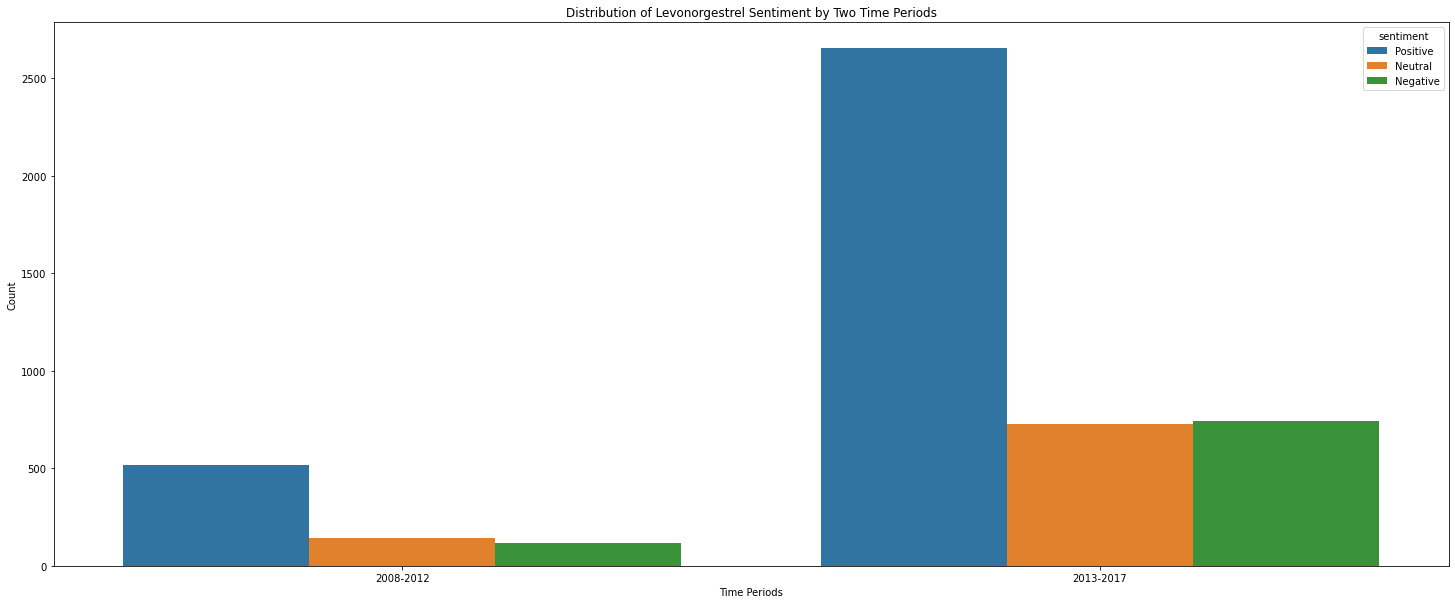

In [74]:
# Let's try plotting sentiment of Levonorgestrel against the two assigned time periods

fig = plt.figure(figsize = (25, 10))

sns.countplot(x='date_column', hue='sentiment', data=bc_data[bc_data['drugName'] == 'Levonorgestrel'], hue_order=hue_order, palette='tab10')

hue_order = ['Positive', 'Neutral', 'Negative']
# plt.xticks(rotation=45)
plt.xlabel('Time Periods')
plt.ylabel('Count')
plt.title('Distribution of Levonorgestrel Sentiment by Two Time Periods');

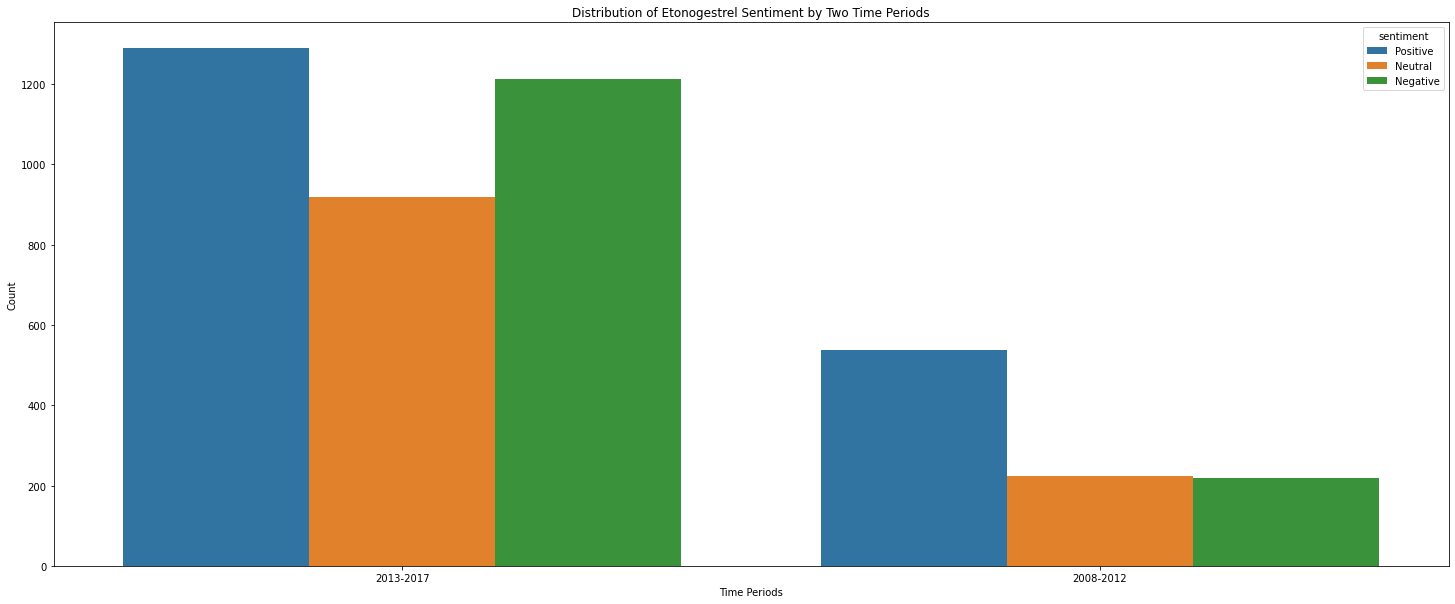

In [75]:
# Let's try plotting sentiment of Etonogestrel against the two assigned time periods

fig = plt.figure(figsize = (25, 10))

sns.countplot(x='date_column', hue='sentiment', data=bc_data[bc_data['drugName'] == 'Etonogestrel'], hue_order=hue_order, palette='tab10')

hue_order = ['Positive', 'Neutral', 'Negative']
# plt.xticks(rotation=45)
plt.xlabel('Time Periods')
plt.ylabel('Count')
plt.title('Distribution of Etonogestrel Sentiment by Two Time Periods');

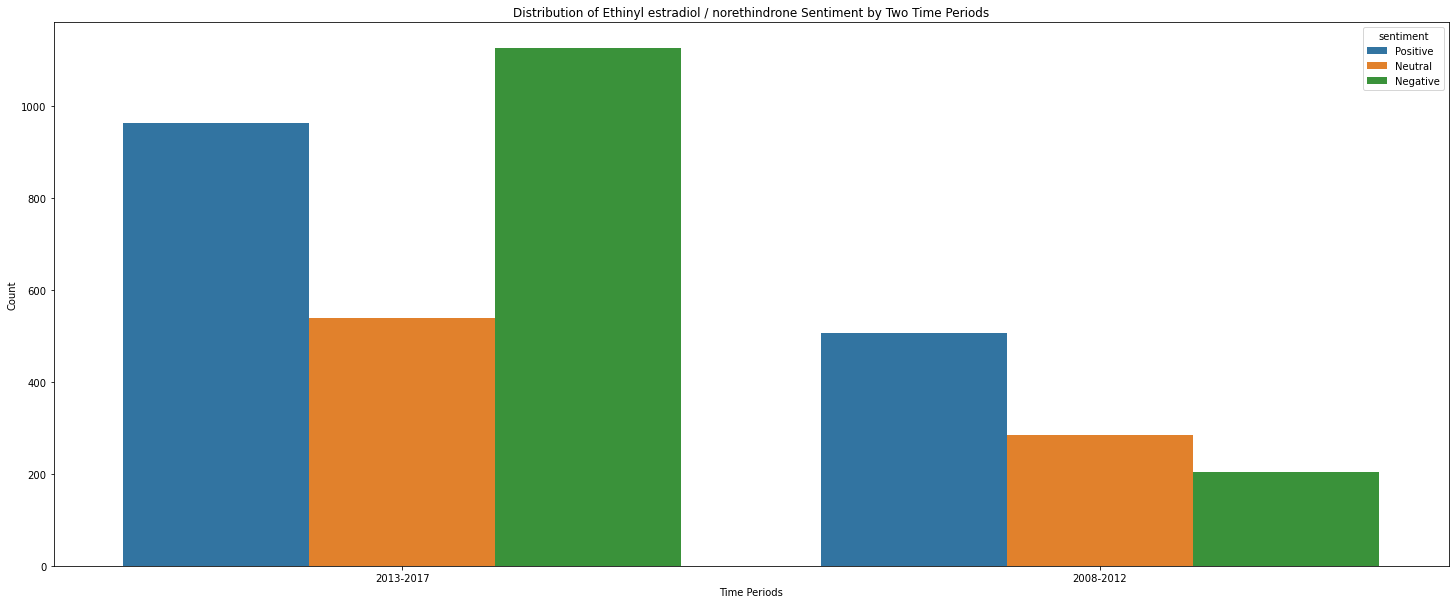

In [76]:
# Let's try plotting sentiment of Ethinyl estradiol / norethindrone against the two assigned time periods

fig = plt.figure(figsize = (25, 10))

sns.countplot(x='date_column', hue='sentiment', data=bc_data[bc_data['drugName'] == 'Ethinyl estradiol / norethindrone'], hue_order=hue_order, palette='tab10')

hue_order = ['Positive', 'Neutral', 'Negative']
# plt.xticks(rotation=45)
plt.xlabel('Time Periods')
plt.ylabel('Count')
plt.title('Distribution of Ethinyl estradiol / norethindrone Sentiment by Two Time Periods');

### Cleaning Text Reviews

In [77]:
# Create function that will lowercase the text

def lower_case(text):
    text = text.lower()
    return text

# Create function to remove the html apostrophes in the text

def apostrophe(text):
    text = text.replace('&#039;', '\'')
    return text

# Want to expand the contractions so we can see if these words have importance

def fixcontractions(text):
    text = contractions.fix(text)
    return text

# Create a function that uses a regex tokenizer to remove punctuation but ignores contraction apostrophes

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+\'?\w+')
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

# Remove stopwords from the reviews

def remove_stopwords(text, stop_words_list = set(stopwords.words('english'))):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    text = ' '.join(text)
    return text

# Create a function that lemmatizes words

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

def clean_text(text):
    text = lower_case(text)
    text = apostrophe(text)
    text = fixcontractions(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [78]:
# Manually testing the contractions.fix function
contractions.fix("I've aren't Tim's got a lovely bunch of coconuts")

"I have are not Tim's got a lovely bunch of coconuts"

In [79]:
# Original review text location 6
bc_data_train['review'][14]

NameError: name 'bc_data_train' is not defined

In [ ]:
# Testing one of the reviews to see what it is doing to the text, as above
clean_text(bc_data_train['review'][14])

In [ ]:
### Plotting the top 10 most common words in the 'text' column in an sns bar chart after applying the clean_text function

text = ' '.join(bc_data['review'])
text = clean_text(text)
text = text.split()

freq = pd.Series(text).value_counts()[:10]
freq = freq.to_frame()
freq = freq.reset_index()
freq.columns = ['word', 'count']
freq = freq.sort_values(by='count', ascending=False)

fig = plt.figure(figsize=(6,4))
sns.barplot(x='count', y='word', data=freq, palette='tab10')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Common Words in Reviews')
plt.show()

# Modeling

In [ ]:
bc_data.info()

### First Simple Model - Count Vectorizer / Logistic Regression / No Features

In [ ]:
X1 = bc_data['review']
y1 = bc_data['sentiment']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=1337)

# For Train Set, apply clean_text function

X_train_1 = X_train_1.apply(clean_text)

### Train - Tokenize the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_1 = X_train_1.apply(lambda x: x.split())
X_train_1 = X_train_1.map(' '.join)

### Train - Vectorize the training data using CountVectorizer

cv = CountVectorizer()
X_train_1 = cv.fit_transform(X_train_1)

### Train - Fit training data to Logistic Regression Model

logit = LogisticRegression()
logit.fit(X_train_1, y_train_1)

### VALIDATION - Perform a cross validation on the logistic regression model

scores = cross_val_score(logit, X_train_1, y_train_1, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean())

In [ ]:
# Logistic Regression Test Set Preprocessing

X_test_1 = X_test_1.apply(clean_text)
X_test_1 = X_test_1.apply(lambda x: x.split())
X_test_1 = X_test_1.map(' '.join)
X_test_1 = cv.transform(X_test_1)

In [ ]:
logit_pred = logit.predict(X_test_1)

In [ ]:
print('Logistic Regression Accuracy: ', accuracy_score(y_test_1, logit_pred))
print('Logistic Regression F1 Score: ', f1_score(y_test_1, logit_pred, average='weighted'))
print('Logistic Regression Precision Score: ', precision_score(y_test_1, logit_pred, average='weighted'))
print('Logistic Regression Recall Score: ', recall_score(y_test_1, logit_pred, average='weighted'))

In [ ]:
### Get scores for the sentiments individually to see

# Quick look at decision matrix for our first model:

### Logistic Regression Confusion Matrix

cm = confusion_matrix(y_test_1, logit_pred)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])

fig_cm1 = plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
3282 +  4476

### Second Model - TFID Vectorizer / Logistic Regression / No Features¶

- Want to test if TFIDF Vectorizer makes a difference compared to Count Vectorizer

In [ ]:
X1_tfidf = bc_data['review']
y1_tfidf = bc_data['sentiment']

X_train_1_tfidf, X_test_1_tfidf, y_train_1_tfidf, y_test_1_tfidf = train_test_split(X1, y1, test_size=0.2, random_state=1337)

# For Train Set, apply clean_text function

X_train_1_tfidf = X_train_1_tfidf.apply(clean_text)

### Train - Tokenize the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_1_tfidf = X_train_1_tfidf.apply(lambda x: x.split())
X_train_1_tfidf = X_train_1_tfidf.map(' '.join)

### Train - Vectorize the training data using CountVectorizer

tfidf = TfidfVectorizer()
X_train_1_tfidf = tfidf.fit_transform(X_train_1_tfidf)

### Train - Fit training data to Logistic Regression Model

logit_tfidf = LogisticRegression()
logit_tfidf.fit(X_train_1_tfidf, y_train_1_tfidf)

### VALIDATION - Perform a cross validation on the decision tree classifier

scores = cross_val_score(logit_tfidf, X_train_1_tfidf, y_train_1_tfidf, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean())

In [ ]:
# Logistic Regression Test (TFIDF) Set Preprocessing

X_test_1_tfidf = X_test_1_tfidf.apply(clean_text)
X_test_1_tfidf = X_test_1_tfidf.apply(lambda x: x.split())
X_test_1_tfidf = X_test_1_tfidf.map(' '.join)
X_test_1_tfidf = cv.transform(X_test_1_tfidf)

In [ ]:
logit_pred_tfidf = logit_tfidf.predict(X_test_1_tfidf)

In [ ]:
### Logistic Regression Confusion Matrix w/ TFIDF

cm = confusion_matrix(y_test_1_tfidf, logit_pred_tfidf)
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])

fig_cm1 = plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print('Logistic Regression (TFIDF) Accuracy: ', accuracy_score(y_test_1_tfidf, logit_pred_tfidf))
print('Logistic Regression (TFIDF) F1 Score: ', f1_score(y_test_1_tfidf, logit_pred_tfidf, average='weighted'))
print('Logistic Regression (TFIDF) Precision Score: ', precision_score(y_test_1_tfidf, logit_pred_tfidf, average='weighted'))
print('Logistic Regression (TFIDF) Recall Score: ', recall_score(y_test_1_tfidf, logit_pred_tfidf, average='weighted'))

- We see here that our Logistic regression model using TFIDF has a lower accuracy than the model with Count Vector. This could possibly be contributed to the fact of class imbalance, and the words that the model is selecting for is the result of the imbalanced classes. Will look at sampling differently in the next model